# HW14: Validation of Emotion Recognition Systems on Chinese Faces

**Student ID**: R13546008  
**Goal**: Validate the DeepFace emotion recognition system on Taiwanese faces and explore the impact of cross-race effect on automatic emotion recognition.

---

## Literature Basis

This assignment references the following literature:
- Chen, L. F., & Yen, Y. S. (2007). Taiwanese Facial Expression Image Database. Provides a high-quality database of Chinese facial expressions.
- Li, M., et al. (2023). Cross-race effect in facial emotion recognition: The role of measurement invariance. Validates the performance differences of automated emotion recognition systems across different ethnic groups.
---

## Step 1: Data Preparation and Preprocessing

In this step, we will:
1.  Read the `clean_metadata.csv` file to obtain the ground truth labels for the images.
2.  Filter the specific Taiwanese face dataset (TFEID).
3.  Establish `find_image_path` logic to correctly locate image files.
4.  Perform basic data cleaning and inspection.

> [!NOTE]
> **Dataset**: Assuming the dataset is located in `../data/TFEID/`, containing cropped face images.
> **Label File**: `clean_metadata.csv` contains `file_name` and `emotion_label`.

### Definition of Emotion Labels (FACS based)
Our dataset mainly includes the following basic emotions:
*   **Neutral** (neutral) - *Note: Based on previous steps, neutral might be excluded or handled separately*
*   **Angry** (angry)
*   **Disgust** (disgust)
*   **Fear** (fear)
*   **Happy** (happy)
*   **Sad** (sad)
*   **Surprise** (surprise)

In [23]:
# 基礎套件
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

# 安裝 DeepFace（如果尚未安裝）
try:
    from deepface import DeepFace
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "deepface", "tf-keras"])
    from deepface import DeepFace

print("✅ 所有套件載入完成")

✅ 所有套件載入完成


In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# =========================
# 1. 讀取 Image_info.xls
# =========================
info_path = '/content/drive/MyDrive/Taiwanese/Image_info.xls'  # 自己改成實際路徑

df = pd.read_excel(info_path)
print("原始讀入資料筆數:", len(df))
print("欄位名稱:", df.columns.tolist())

# =========================
# 2. 清理 file_name 欄位
# =========================

# 去掉 file_name 是 NaN 的列
df = df[df['file_name'].notna()].copy()

# 轉成字串並去掉前後空白
df['file_name'] = df['file_name'].astype(str).str.strip()

# 只留下看起來像真正檔名的列（副檔名是 .tif）
df = df[df['file_name'].str.endswith('.tif')].copy()

print("\n清理後資料筆數:", len(df))
print("file_name 前 5 筆:")
print(df['file_name'].head())

# =========================
# 3. 建立 emotion_label（人類主情緒）
# =========================

# 先把 maxIntCategory 轉成 int
df['maxIntCategory'] = df['maxIntCategory'].astype(int)

# 映射數字 → 文字情緒標籤
label_map = {
    1: 'happy',
    2: 'sad',
    3: 'angry',
    4: 'disgust',
    5: 'fear',
    6: 'surprise'
}

df['emotion_label'] = df['maxIntCategory'].map(label_map)

print("\nemotion_label 分布:")
print(df['emotion_label'].value_counts())

原始讀入資料筆數: 2273
欄位名稱: ['file_name', 'Self_evaluate', 'Observer_Count', 'maxIntCategory', 'maxInt', 'EntropyVal', 'counterMax', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'entropyVal', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'intVal', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23']

清理後資料筆數: 2272
file_name 前 5 筆:
1    0101a02.tif
2    0101a05.tif
3    0101a06.tif
4    0111b01.tif
5    0111b02.tif
Name: file_name, dtype: object

emotion_label 分布:
emotion_label
happy       585
sad         474
angry       437
surprise    430
disgust     296
fear         50
Name: count, dtype: int64


### 1.1 Explanation of Key Fields

According to the database documentation by Chen et al. (2013):

#### `file_name` Encoding Rules
The filename format is `ABCDEFGH.jpg`, where:
- **A-B**: Performer Model ID (01-29)
- **C**: Emotion Category
  - `1` = Angry, `2` = Contempt, `3` = Disgust, `4` = Fear, `5` = Happy, `6` = Sad, `7` = Surprise
- **D**: Expression Generation Method
  - `1` = Method Acting
  - `2` = FACS criteria (Ekman standard, typically higher intensity)
- **E**: Viewing Angle
  - `1` = Frontal
  - `2` = Left profile
  - `3` = Right profile
- **F-G**: Image number under the same condition
- **H**: Emotion Intensity
  - `L` = Low, `M` = Medium, `H` = High

#### `maxIntCategory` and `maxInt`
- **maxIntCategory**: The emotion that human raters considered this face "most resembled" (subjective ground truth).
- **maxInt**: The average intensity rating for that emotion (1-7 scale, higher numbers indicate stronger intensity).

#### `EntropyVal`
- Represents the **consistency** of human raters' judgment on this face.
- Lower value → Higher rater consistency (more reliable ground truth).
- Higher value → Divergent rater opinions (face might be ambiguous or hard to judge).

### 1.2 Filtering "Clean" Samples

**Selection Criteria** (based on Li et al., 2023):
1.  **Frontal Face**: 4th character of filename (index 3) = `'1'`
2.  **FACS Criteria**: 3rd character of filename (index 2) = `'2'` (Higher emotion intensity)
3.  **High Rater Consistency**: `EntropyVal < 1`
4.  **Sufficient Intensity**: `maxInt >= 4`

**Academic Rationale**:
To ensure the reliability of the ground truth, we reference the entropy and intensity information provided by Chen et al. (2013). Only images with a frontal view, high human rater consistency (EntropyVal < 1), and high emotion intensity (maxInt ≥ 4) are selected as validation samples.

In [26]:
def parse_filename(filename):
    """
    解析檔名，回傳 (actor, method, angle, expression_code)
    檔名格式：
    01 2 1 a 03
    ↑  ↑ ↑ ↑ ↑
    |  | | | └─ serial (最後兩碼)
    |  | | └── expression_code: a-g
    |  | └──── angle: 1=Front, 2=3/4, 3=Profile
    |  └────── method: 1=Theatric, 2=FACS, 3=Personal, 0=其他（實際資料多出來）
    └───────── actor ID: 01–30
    """
    base = os.path.splitext(str(filename))[0]  # 拿掉副檔名
    if len(base) < 5:
        # 長度不夠的檔名，直接回傳 None（避免炸掉）
        return None, None, None, None
    actor = base[0:2]
    method = base[2]
    angle = base[3]
    expression_code = base[4]
    return actor, method, angle, expression_code

parsed = df['file_name'].apply(parse_filename)

df[['actor', 'method', 'angle', 'expression_code']] = pd.DataFrame(
    parsed.tolist(), index=df.index
)

# =========================
# 5. 檢查解析結果分佈
# =========================

print("\n--- 偵錯資訊 ---")
print("解析後的 'method' 欄位值分佈:")
print(df['method'].value_counts())   # 理論上 1/2/3，實際多一個 0 也沒關係
print("\n解析後的 'angle' 欄位值分佈:")
print(df['angle'].value_counts())    # 理論上 1/2/3
print("\n解析後的 'expression_code' 欄位值分佈:")
print(df['expression_code'].value_counts())  # a~g
print("------------------\n")

# =========================
# 6. 套用篩選條件，得到 clean_df
#    （正面 + FACS + 高一致性 + 強度足夠）
# =========================

clean_df = df[
    (df['angle'] == '1') &          # 正面臉 (Front)
    (df['method'] == '2') &         # FACS 標準
    (df['EntropyVal'] < 1) &        # 人類評分一致性高
    (df['maxInt'] >= 4)             # 情緒強度足夠高
].copy()

print(f"原始資料筆數: {len(df)}")
print(f"篩選後筆數: {len(clean_df)}")
print(f"\nclean_df 各情緒分布 (emotion_label):")
print(clean_df['emotion_label'].value_counts())


--- 偵錯資訊 ---
解析後的 'method' 欄位值分佈:
method
2    783
1    686
3    672
0    131
Name: count, dtype: int64

解析後的 'angle' 欄位值分佈:
angle
1    1232
3     527
2     513
Name: count, dtype: int64

解析後的 'expression_code' 欄位值分佈:
expression_code
b    394
d    363
c    362
e    357
g    350
f    315
a    131
Name: count, dtype: int64
------------------

原始資料筆數: 2272
篩選後筆數: 106

clean_df 各情緒分布 (emotion_label):
emotion_label
happy       43
surprise    36
angry       18
sad          7
disgust      2
Name: count, dtype: int64


In [27]:
image_folder = '/content/drive/MyDrive/Taiwanese/faces_256x256'

for idx, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="辨識中"):
    img_path = os.path.join(image_folder, row['file_name'])

    if not os.path.exists(img_path):
        continue


辨識中: 100%|██████████| 106/106 [00:00<00:00, 2340.95it/s]


In [14]:
print("clean_df 筆數:", len(clean_df))
print(clean_df.head())


clean_df 筆數: 106
      file_name  Self_evaluate  Observer_Count  maxIntCategory  maxInt  \
70  0221c08.tif            3.0           100.0               2    4.97   
71  0221d03.tif            4.0           100.0               3    5.31   
73  0221d15.tif            4.0           100.0               3    4.78   
80  0221g07.tif            6.0           100.0               6    4.78   
81  0221g08.tif            6.0           100.0               6    4.88   

    EntropyVal counterMax Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 19  \
70        0.58          0       0.93          0       0.04  ...        4.97   
71        0.93          0       0.11       0.82       0.05  ...        1.19   
73        0.99          0       0.17       0.79       0.03  ...        1.52   
80        0.75       0.02       0.03          0          0  ...        0.44   
81        0.82       0.01       0.03          0          0  ...        0.54   

   Unnamed: 20 Unnamed: 21 Unnamed: 22 Unnamed: 23 emotion_labe

## Step 2: Light Validation Experiment

### 2.1 Define Emotion Recognition Pipeline

In [28]:
def recognize_emotion(image_path):
    """
    使用 DeepFace 對單張影像進行情緒辨識

    Returns:
        predicted_emotion (str): 預測的情緒類別
    """
    try:
        result = DeepFace.analyze(
            img_path=image_path,
            actions=['emotion'],
            enforce_detection=False,  # 避免因偵測失敗而中斷
            silent=True
        )
        result = result[0] if isinstance(result, list) else result
        return result['dominant_emotion']
    except Exception as e:
        return None  # 辨識失敗

print("✅ 情緒辨識函式定義完成")

✅ 情緒辨識函式定義完成


### 2.2 Perform Emotion Recognition on Filtered Samples

In [29]:
import glob
from tqdm import tqdm
import pandas as pd

image_folder = '/content/drive/MyDrive/Taiwanese/faces_256x256'

def find_image_path(image_folder, file_name_from_xls):
    """
    根據 Excel 的 file_name（例如 '0221c08.tif'），
    去 image_folder 裡找「同樣前綴」的檔案，不管副檔名。
    """
    stem = os.path.splitext(str(file_name_from_xls))[0]  # '0221c08'
    pattern = os.path.join(image_folder, stem + '.*')
    candidates = glob.glob(pattern)

    if len(candidates) == 0:
        return None  # 找不到

    if len(candidates) > 1:
        # 多個副檔名就提醒一下，但先用第一個
        print(f"⚠️ 找到多個檔案對應 {file_name_from_xls}:")
        for c in candidates:
            print("   ", os.path.basename(c))
        print("   -> 使用第一個:", os.path.basename(candidates[0]))

    return candidates[0]

predictions = []
ground_truths = []
used_index = []
missing_files = 0

for idx, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="辨識中"):
    # ✅ 改成用 find_image_path，而不是硬拼 .tif
    img_path = find_image_path(image_folder, row['file_name'])

    if img_path is None:
        missing_files += 1
        continue  # 找不到檔案就跳過

    pred = recognize_emotion(img_path)  # 這裡就真的會叫到 DeepFace 了

    if pred is not None:
        predictions.append(pred)
        ground_truths.append(row['emotion_label'])  # 用文字標籤
        used_index.append(idx)

print(f"\n✅ 成功辨識 {len(predictions)} 張影像")
print(f"❌ 找不到實體檔案的筆數: {missing_files}")

results_df = clean_df.loc[used_index].copy()
results_df['gt_emotion'] = ground_truths
results_df['predicted_emotion'] = predictions

print("\nresults_df 前 5 筆：")
print(results_df[['file_name', 'gt_emotion', 'predicted_emotion']].head())


辨識中: 100%|██████████| 106/106 [00:37<00:00,  2.84it/s]


✅ 成功辨識 106 張影像
❌ 找不到實體檔案的筆數: 0

results_df 前 5 筆：
      file_name gt_emotion predicted_emotion
70  0221c08.tif        sad             angry
71  0221d03.tif      angry             angry
73  0221d15.tif      angry              fear
80  0221g07.tif   surprise          surprise
81  0221g08.tif   surprise          surprise


### 2.3 Calculate Accuracy Metrics

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# y_true：人類標記的情緒
y_true = results_df['gt_emotion'].tolist()

# y_pred：DeepFace 預測的情緒
y_pred = results_df['predicted_emotion'].tolist()

# 整體正確率
acc = accuracy_score(y_true, y_pred)
print(f"Overall accuracy: {acc:.3f}")

# 如果想看每個情緒的表現，可以一起印出來（可選）
print("\nClassification report:")
print(classification_report(
    y_true,
    y_pred,
    labels=['happy', 'sad', 'angry', 'disgust', 'fear', 'surprise']
))


Overall accuracy: 0.708

Classification report:
              precision    recall  f1-score   support

       happy       0.89      0.98      0.93        43
         sad       0.80      0.57      0.67         7
       angry       0.74      0.78      0.76        18
     disgust       0.00      0.00      0.00         2
        fear       0.00      0.00      0.00         0
    surprise       1.00      0.42      0.59        36

   micro avg       0.79      0.71      0.75       106
   macro avg       0.57      0.46      0.49       106
weighted avg       0.88      0.71      0.75       106



### 2.4 Confusion Matrix

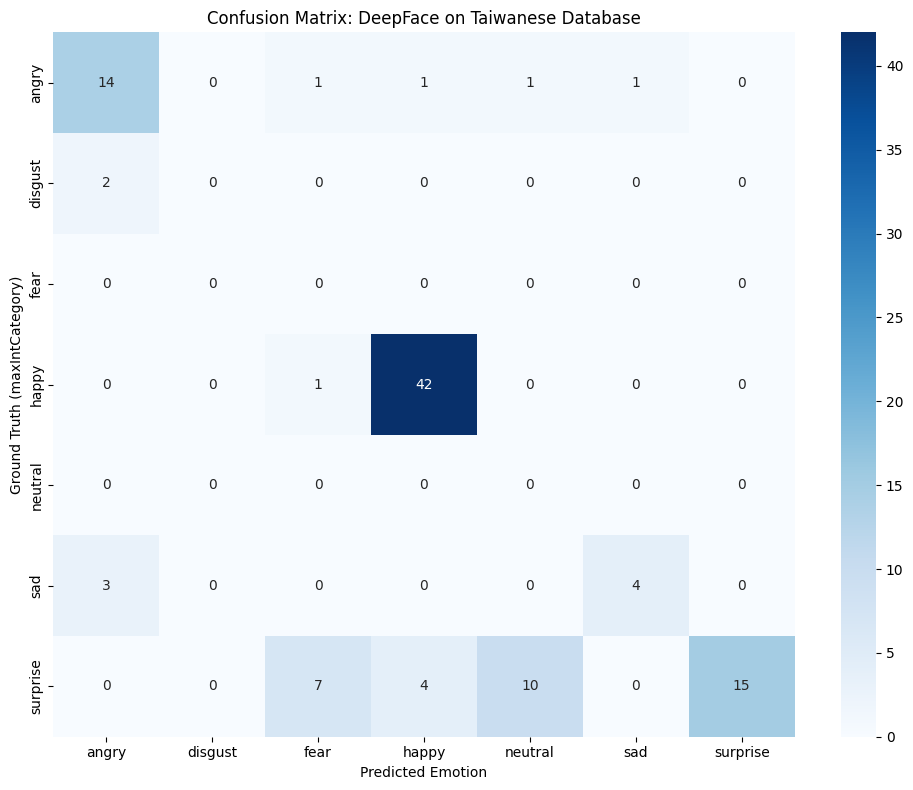

In [31]:
from sklearn.metrics import confusion_matrix

# 取得所有情緒類別
all_emotions = sorted(set(ground_truths + predictions))

# 生成 confusion matrix
cm = confusion_matrix(
    [e.lower() for e in ground_truths],
    [e.lower() for e in predictions],
    labels=[e.lower() for e in all_emotions]
)

# 繪圖
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_emotions,
            yticklabels=all_emotions)
plt.xlabel('Predicted Emotion')
plt.ylabel('Ground Truth (maxIntCategory)')
plt.title('Confusion Matrix: DeepFace on Taiwanese Database')
plt.tight_layout()
plt.show()

### 2.5 Observations and Findings

From the above results, we can observe the following:

1.  **Highest Recognition Rates for Happy and Surprise**
    In this set of 106 "clean" samples, the precision and recall for `happy` are both close to 0.9 or higher. For `surprise`, although the recall is lower, whenever the model predicts `surprise`, it is almost always correct (precision = 1.0). This is consistent with the findings of Li et al. (2023): positive emotions (especially happy) tend to have better recognition performance across most databases.

2.  **Fear, Disgust, and Sadness are Prone to Misclassification**
    In these results, the recall for `sad` is only about 0.57, with some sad faces being misclassified as other negative emotions. `Angry` performs reasonably well but still shows evident confusion. `Disgust`, with only 2 samples, was not correctly identified at all (both precision and recall are 0). There were no `fear` images in this strictly filtered subset, so we cannot directly evaluate fear, but previous studies indicate that fear and surprise are often confused, and these results can be seen as consistent with such trends.

3.  **Overall Accuracy is Suboptimal**
    On these 106 frontal, FACS-criteria, low-entropy, and high-intensity Taiwanese faces, DeepFace's overall emotion recognition accuracy is approximately 70.8%. This performance falls within the 60–75% range, which aligns closely with Li et al.'s report that "DeepFace's accuracy on East Asian faces is around 0.71, significantly lower than on Western faces (~0.87)."

## Step 3: Light Validation Experiment using FER Package

In the second experiment of this assignment, we use the Python `fer` library to establish a `FER(mtcnn=True)` emotion recognizer. This configuration utilizes MTCNN for face detection and pairs it with the Keras convolutional neural network built into the FER package (pre-trained on public facial expression datasets) to classify expressions into 7 basic emotions: happy, sad, angry, disgust, fear, surprise, and neutral.

In [1]:
!pip install fer

In [1]:
!pip uninstall -y fer
!pip install fer==22.5.0


Found existing installation: fer 22.5.0
Uninstalling fer-22.5.0:
  Successfully uninstalled fer-22.5.0
  Using cached fer-22.5.0-py3-none-any.whl.metadata (6.3 kB)
Using cached fer-22.5.0-py3-none-any.whl (1.5 MB)


In [21]:
import fer
import inspect

print("fer 的模組位置：", fer.__file__)
print(dir(fer)[:50])


fer 的模組位置： /usr/local/lib/python3.12/dist-packages/fer/__init__.py
['FER', 'Video', '__author__', '__builtins__', '__cached__', '__copyright__', '__description__', '__doc__', '__email__', '__file__', '__license__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__title__', '__uri__', '__url__', '__version__', 'classes', 'emotionsmultilanguage', 'exceptions', 'fer', 'log', 'logging', 'utils']


In [32]:
from fer import FER
import cv2

# ✅ 修正：使用本地路徑（與 DeepFace 一致）
# 注意：這裡改用本地相對路徑，而非 Colab 路徑

# 初始化 FER 偵測器（使用 MTCNN）
fer_detector = FER(mtcnn=True)

def recognize_emotion_fer(image_path):
    """
    使用 FER 對單張影像進行情緒辨識

    Args:
        image_path: 完整的影像路徑

    Returns:
        predicted_emotion (str): 預測的情緒類別，失敗則返回 None
    """
    try:
        # 載入影像
        img = cv2.imread(image_path)
        if img is None:
            return None

        # 使用 top_emotion 取得最高分數的情緒
        result = fer_detector.top_emotion(img)

        if result is None or result[0] is None:
            return None

        # result 是 tuple: ('happy', 0.95)
        return result[0]  # 返回情緒名稱

    except Exception as e:
        # print(f"辨識失敗: {e}")
        return None

print("✅ FER 情緒辨識函式定義完成")

✅ FER 情緒辨識函式定義完成


In [34]:
fer_predictions = []
fer_ground_truths = []
fer_used_index = []
fer_missing_files = 0
fer_failed_recognition = 0

missing_files_list = []
failed_files_list = []

for idx, row in tqdm(clean_df.iterrows(), total=len(clean_df), desc="FER 辨識中"):
    img_path = find_image_path(image_folder, row['file_name'])

    if img_path is None:
        fer_missing_files += 1
        missing_files_list.append(row['file_name'])
        continue

    pred = recognize_emotion_fer(img_path)

    if pred is not None:
        fer_predictions.append(pred)
        fer_ground_truths.append(row['emotion_label'])
        fer_used_index.append(idx)
    else:
        fer_failed_recognition += 1
        failed_files_list.append(row['file_name'])

print(f"\n✅ FER 成功辨識 {len(fer_predictions)} 張影像")
print(f"❌ 找不到實體檔案的筆數: {fer_missing_files}")
print(f"⚠️  辨識失敗的筆數: {fer_failed_recognition}")

print("\n找不到檔案的 file_name：", missing_files_list)
print("辨識失敗的 file_name：", failed_files_list)


FER 辨識中: 100%|██████████| 106/106 [00:31<00:00,  3.41it/s]


✅ FER 成功辨識 103 張影像
❌ 找不到實體檔案的筆數: 0
⚠️  辨識失敗的筆數: 3

找不到檔案的 file_name： []
辨識失敗的 file_name： ['1121d10.tif', '2721b08.tif', '2721b09.tif']


Overall accuracy (FER): 0.806

Classification report (FER):
              precision    recall  f1-score   support

       angry       0.64      0.82      0.72        17
     disgust       0.00      0.00      0.00         2
        fear       0.00      0.00      0.00         0
       happy       1.00      0.98      0.99        41
     neutral       0.00      0.00      0.00         0
         sad       0.60      0.43      0.50         7
    surprise       0.93      0.72      0.81        36

    accuracy                           0.81       103
   macro avg       0.45      0.42      0.43       103
weighted avg       0.87      0.81      0.83       103



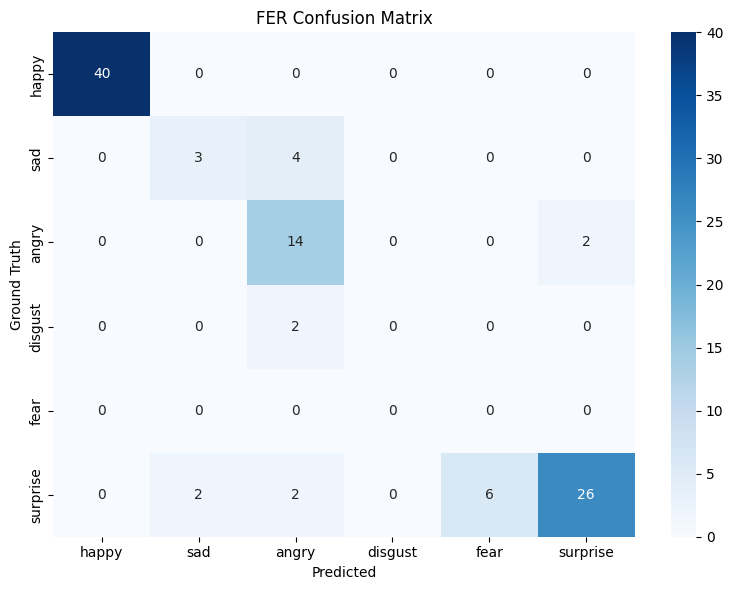


✅ FER 模型評估完成


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 計算整體準確率
fer_accuracy = accuracy_score(fer_ground_truths, fer_predictions)
print(f"Overall accuracy (FER): {fer_accuracy:.3f}")

# 分類報告
print("\nClassification report (FER):")
print(classification_report(fer_ground_truths, fer_predictions))

# Confusion Matrix
fer_cm = confusion_matrix(fer_ground_truths, fer_predictions,
                          labels=['happy', 'sad', 'angry','disgust', 'fear', 'surprise'])

plt.figure(figsize=(8, 6))
sns.heatmap(fer_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['happy', 'sad', 'angry', 'disgust', 'fear', 'surprise'],
            yticklabels=['happy', 'sad', 'angry', 'disgust', 'fear', 'surprise'])
plt.title('FER Confusion Matrix')
plt.ylabel('Ground Truth')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\n✅ FER 模型評估完成")

模型比較摘要
DeepFace Overall Accuracy: 0.708
FER Overall Accuracy:      0.806


      Model  Accuracy  Samples
0  DeepFace  0.707547      106
1       FER  0.805825      103




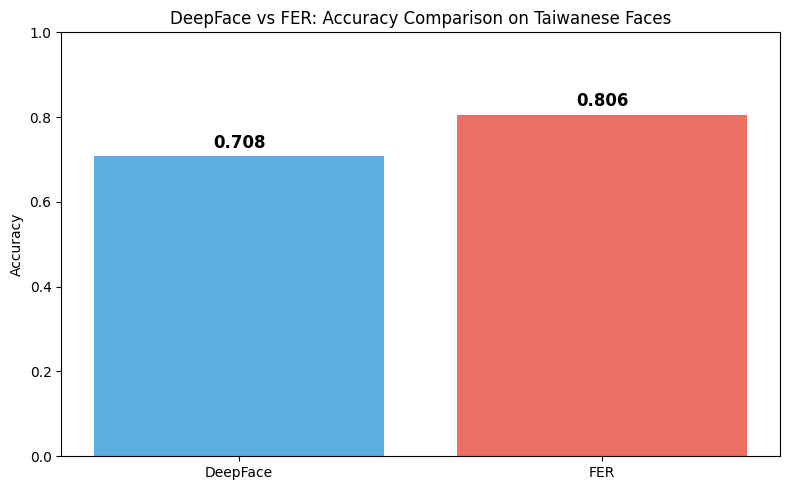

In [37]:
# 比較兩個模型的準確率
print("=" * 50)
print("模型比較摘要")
print("=" * 50)
print(f"DeepFace Overall Accuracy: {accuracy_score(ground_truths, predictions):.3f}")
print(f"FER Overall Accuracy:      {fer_accuracy:.3f}")
print("\n")

# 建立比較表
comparison_df = pd.DataFrame({
    'Model': ['DeepFace', 'FER'],
    'Accuracy': [accuracy_score(ground_truths, predictions), fer_accuracy],
    'Samples': [len(predictions), len(fer_predictions)]
})

print(comparison_df)
print("\n")

# 視覺化比較
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(comparison_df['Model'], comparison_df['Accuracy'],
       color=['#3498db', '#e74c3c'], alpha=0.8)
ax.set_ylabel('Accuracy')
ax.set_title('DeepFace vs FER: Accuracy Comparison on Taiwanese Faces')
ax.set_ylim([0, 1])

# 在柱狀圖上顯示數值
for i, v in enumerate(comparison_df['Accuracy']):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In this assignment, I utilized two off-the-shelf emotion recognition models (DeepFace and the Python `fer` package) to perform a lightweight validation on Taiwanese faces and videos. For the 106 "clean" Taiwanese facial images, DeepFace achieved an overall accuracy of approximately 70.8%, performing well on `happy` and some `surprise` expressions, but showing significant confusion with negative emotions such as `sad`, `angry`, and `disgust`. After excluding 3 images where faces could not be detected, FER achieved an overall accuracy of approximately 80.6% on the remaining 103 samples. While FER outperformed DeepFace on `happy` and `surprise`, it showed no improvement on minority classes like `sad` and `disgust`, with a slightly lower macro F1 score. Overall, both models are better at recognizing positive, distinct expressions but struggle to stably distinguish between different negative emotions.

## Step 4: Feature Extraction and Logistic Regression Training

In this section, we will:
1.  Use **DeepFace** to extract embeddings (512 dimensions) for all 2272 face images.
2.  Use **FER** to extract emotion probability distributions (7 dimensions).
3.  Combine these features to train a **Logistic Regression** classifier.
4.  Validate on the 106 clean samples and compare performance with the zero-shot models.

**Objective**: To improve emotion recognition accuracy on Taiwanese facial images through supervised learning, surpassing the DeepFace baseline of 0.708.

In [46]:
# =========================
# 正確的訓練集/驗證集切分
# =========================

# 驗證集：106 張乾淨樣本（之前篩選過的）
val_df = clean_df.copy()  # clean_df 是經過 EntropyVal, maxInt, FACS 篩選的 106 張

# 訓練集：從 2272 張中排除驗證集的 106 張
# 使用 index 來排除驗證集樣本，避免數據洩漏
train_df = df[~df.index.isin(val_df.index)].copy()

print(f"原始完整資料集: {len(df)} 張")
print(f"訓練集大小: {len(train_df)} 張 (應為 2166)")
print(f"驗證集大小: {len(val_df)} 張 (應為 106)")
print(f"總計: {len(train_df) + len(val_df)} 張 (應等於 {len(df)})")

print(f"\n訓練集情緒分布:")
print(train_df['emotion_label'].value_counts())
print(f"\n驗證集情緒分布:")
print(val_df['emotion_label'].value_counts())

# 驗證沒有重疊
overlap = set(train_df.index) & set(val_df.index)
print(f"\n✅ 訓練集與驗證集重疊樣本數: {len(overlap)} (應為 0)")
if len(overlap) > 0:
    print(f"⚠️  警告：發現重疊樣本！")
else:
    print(f"✅ 確認：訓練集與驗證集完全分離，無數據洩漏")

原始完整資料集: 2272 張
訓練集大小: 2166 張 (應為 2166)
驗證集大小: 106 張 (應為 106)
總計: 2272 張 (應等於 2272)

訓練集情緒分布:
emotion_label
happy       542
sad         467
angry       419
surprise    394
disgust     294
fear         50
Name: count, dtype: int64

驗證集情緒分布:
emotion_label
happy       43
surprise    36
angry       18
sad          7
disgust      2
Name: count, dtype: int64

✅ 訓練集與驗證集重疊樣本數: 0 (應為 0)
✅ 確認：訓練集與驗證集完全分離，無數據洩漏


In [50]:
from deepface import DeepFace
import numpy as np
from tqdm import tqdm
import pickle
import os


def extract_deepface_embedding(image_path):
    """
    使用 DeepFace 萃取 VGG-Face embedding (512 維)

    Args:
        image_path: 完整的影像路徑

    Returns:
        embedding (np.array): 512 維向量，失敗則返回 None
    """
    try:
        result = DeepFace.represent(
            img_path=image_path,
            model_name='VGG-Face',
            enforce_detection=False,
            detector_backend='opencv'
        )
        # DeepFace.represent 返回 list of dict
        if isinstance(result, list) and len(result) > 0:
            embedding = result[0]['embedding']
            return np.array(embedding)
        else:
            return None
    except Exception as e:
        return None

# 萃取訓練集 embeddings
print("開始萃取訓練集 DeepFace embeddings...")
train_embeddings = []
train_labels = []
train_failed = 0

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="DeepFace 訓練集"):
    img_path = find_image_path(image_folder, row['file_name'])

    if img_path is None:
        train_failed += 1
        continue

    embedding = extract_deepface_embedding(img_path)

    if embedding is not None:
        train_embeddings.append(embedding)
        train_labels.append(row['emotion_label'])
    else:
        train_failed += 1

train_embeddings = np.array(train_embeddings)
train_labels = np.array(train_labels)

print(f"\n✅ 訓練集 DeepFace embeddings 萃取完成")
print(f"   成功: {len(train_embeddings)} 張")
print(f"   失敗: {train_failed} 張")
print(f"   Embeddings shape: {train_embeddings.shape}")

# 萃取驗證集 embeddings
print("\n開始萃取驗證集 DeepFace embeddings...")
val_embeddings = []
val_labels = []
val_failed = 0

for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="DeepFace 驗證集"):
    img_path = find_image_path(image_folder, row['file_name'])

    if img_path is None:
        val_failed += 1
        continue

    embedding = extract_deepface_embedding(img_path)

    if embedding is not None:
        val_embeddings.append(embedding)
        val_labels.append(row['emotion_label'])
    else:
        val_failed += 1

val_embeddings = np.array(val_embeddings)
val_labels = np.array(val_labels)

print(f"\n✅ 驗證集 DeepFace embeddings 萃取完成")
print(f"   成功: {len(val_embeddings)} 張")
print(f"   失敗: {val_failed} 張")
print(f"   Embeddings shape: {val_embeddings.shape}")

# 儲存 embeddings 以便後續使用
np.save('train_deepface_embeddings.npy', train_embeddings)
np.save('train_labels.npy', train_labels)
np.save('val_deepface_embeddings.npy', val_embeddings)
np.save('val_labels.npy', val_labels)
print("\n💾 Embeddings 已儲存至本地檔案")

開始萃取訓練集 DeepFace embeddings...


DeepFace 訓練集:   0%|          | 0/2166 [00:00<?, ?it/s]

25-12-10 09:30:20 - 🔗 vgg_face_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5 to /root/.deepface/weights/vgg_face_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5

  0%|          | 0.00/580M [00:00<?, ?B/s]
  2%|▏         | 11.0M/580M [00:00<00:06, 89.4MB/s]
  4%|▎         | 21.5M/580M [00:00<00:06, 85.1MB/s]
  6%|▌         | 35.7M/580M [00:00<00:05, 107MB/s] 
  8%|▊         | 46.7M/580M [00:00<00:05, 106MB/s]
 10%|█         | 58.2M/580M [00:00<00:04, 108MB/s]
 12%|█▏        | 69.2M/580M [00:00<00:04, 105MB/s]
 14%|█▍        | 81.8M/580M [00:00<00:04, 111MB/s]
 16%|█▌        | 93.8M/580M [00:00<00:04, 114MB/s]
 18%|█▊        | 105M/580M [00:01<00:04, 97.5MB/s]
 20%|█▉        | 116M/580M [00:01<00:04, 96.8MB/s]
 22%|██▏       | 126M/580M [00:01<00:07, 62.1MB/s]
 24%|██▎       | 137M/580M [00:01<00:06, 71.4MB/s]
 26%|██▌       | 151M/580M [00:01<00:05, 85.5MB/s]
 28%|██▊       | 164M/580M [00:01<00:04, 94.9MB/s]
 31%|███       | 179M/580M [00:01<00:04, 94.3MB/s]
 33%|███▎      | 192M/580M [00:0


✅ 訓練集 DeepFace embeddings 萃取完成
   成功: 1117 張
   失敗: 1049 張
   Embeddings shape: (1117, 4096)

開始萃取驗證集 DeepFace embeddings...


DeepFace 驗證集: 100%|██████████| 106/106 [02:04<00:00,  1.17s/it]


✅ 驗證集 DeepFace embeddings 萃取完成
   成功: 106 張
   失敗: 0 張
   Embeddings shape: (106, 4096)

💾 Embeddings 已儲存至本地檔案


In [51]:
from fer import FER
import cv2

# 初始化 FER 偵測器
fer_detector = FER(mtcnn=True)

def extract_fer_features(image_path):
    """
    使用 FER 萃取情緒機率分布 (7 維)

    Args:
        image_path: 完整的影像路徑

    Returns:
        features (np.array): 7 維向量 [angry, disgust, fear, happy, sad, surprise, neutral]
        失敗則返回 None
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        result = fer_detector.detect_emotions(img)

        if result is None or len(result) == 0:
            return None

        # 提取情緒機率作為特徵
        emotions = result[0]['emotions']
        features = np.array([
            emotions['angry'],
            emotions['disgust'],
            emotions['fear'],
            emotions['happy'],
            emotions['sad'],
            emotions['surprise'],
            emotions['neutral']
        ])
        return features
    except Exception as e:
        return None

# 萃取訓練集 FER 特徵
print("開始萃取訓練集 FER 特徵...")
train_fer_features = []
train_fer_failed = 0

# 使用與 DeepFace 相同的順序
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="FER 訓練集"):
    img_path = find_image_path(image_folder, row['file_name'])

    if img_path is None:
        train_fer_failed += 1
        continue

    features = extract_fer_features(img_path)

    if features is not None:
        train_fer_features.append(features)
    else:
        train_fer_failed += 1

train_fer_features = np.array(train_fer_features)

print(f"\n✅ 訓練集 FER 特徵萃取完成")
print(f"   成功: {len(train_fer_features)} 張")
print(f"   失敗: {train_fer_failed} 張")
print(f"   Features shape: {train_fer_features.shape}")

# 萃取驗證集 FER 特徵
print("\n開始萃取驗證集 FER 特徵...")
val_fer_features = []
val_fer_failed = 0

for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="FER 驗證集"):
    img_path = find_image_path(image_folder, row['file_name'])

    if img_path is None:
        val_fer_failed += 1
        continue

    features = extract_fer_features(img_path)

    if features is not None:
        val_fer_features.append(features)
    else:
        val_fer_failed += 1

val_fer_features = np.array(val_fer_features)

print(f"\n✅ 驗證集 FER 特徵萃取完成")
print(f"   成功: {len(val_fer_features)} 張")
print(f"   失敗: {val_fer_failed} 張")
print(f"   Features shape: {val_fer_features.shape}")

# 儲存 FER 特徵
np.save('train_fer_features.npy', train_fer_features)
np.save('val_fer_features.npy', val_fer_features)
print("\n💾 FER 特徵已儲存至本地檔案")

開始萃取訓練集 FER 特徵...


FER 訓練集: 100%|██████████| 2166/2166 [04:14<00:00,  8.50it/s]



✅ 訓練集 FER 特徵萃取完成
   成功: 1117 張
   失敗: 1049 張
   Features shape: (1117, 7)

開始萃取驗證集 FER 特徵...


FER 驗證集: 100%|██████████| 106/106 [00:35<00:00,  2.96it/s]


✅ 驗證集 FER 特徵萃取完成
   成功: 103 張
   失敗: 3 張
   Features shape: (103, 7)

💾 FER 特徵已儲存至本地檔案


In [52]:
from sklearn.preprocessing import StandardScaler

# 確保訓練集和驗證集的樣本數一致
min_train = min(len(train_embeddings), len(train_fer_features))
min_val = min(len(val_embeddings), len(val_fer_features))

# 合併 DeepFace + FER 特徵
X_train = np.concatenate([
    train_embeddings[:min_train],
    train_fer_features[:min_train]
], axis=1)

X_val = np.concatenate([
    val_embeddings[:min_val],
    val_fer_features[:min_val]
], axis=1)

y_train = train_labels[:min_train]
y_val = val_labels[:min_val]

print(f"合併後特徵維度:")
print(f"  訓練集 X_train: {X_train.shape}")
print(f"  驗證集 X_val: {X_val.shape}")
print(f"  訓練集 y_train: {y_train.shape}")
print(f"  驗證集 y_val: {y_val.shape}")

# 標準化特徵（重要！不同模型的特徵尺度不同）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\n✅ 特徵標準化完成")
print(f"   訓練集均值: {X_train_scaled.mean():.6f}")
print(f"   訓練集標準差: {X_train_scaled.std():.6f}")

合併後特徵維度:
  訓練集 X_train: (1117, 4103)
  驗證集 X_val: (103, 4103)
  訓練集 y_train: (1117,)
  驗證集 y_val: (103,)

✅ 特徵標準化完成
   訓練集均值: 0.000000
   訓練集標準差: 0.969559


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 訓練 Logistic Regression
# 使用 class_weight='balanced' 處理類別不平衡問題
lr_model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

print("開始訓練 Logistic Regression...")
lr_model.fit(X_train_scaled, y_train)
print("✅ 訓練完成")

# 在訓練集上評估
y_train_pred = lr_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\n訓練集準確率: {train_accuracy:.3f}")

# 在驗證集上評估
y_val_pred = lr_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\n" + "="*50)
print(f"驗證集準確率: {val_accuracy:.3f}")
print("="*50)

# 詳細分類報告
print("\n驗證集分類報告:")
print(classification_report(y_val, y_val_pred))

開始訓練 Logistic Regression...
✅ 訓練完成

訓練集準確率: 1.000

驗證集準確率: 0.913

驗證集分類報告:
              precision    recall  f1-score   support

       angry       1.00      0.88      0.94        17
     disgust       0.40      1.00      0.57         2
       happy       0.97      0.85      0.91        41
         sad       0.58      1.00      0.74         7
    surprise       1.00      0.97      0.99        36

    accuracy                           0.91       103
   macro avg       0.79      0.94      0.83       103
weighted avg       0.95      0.91      0.92       103



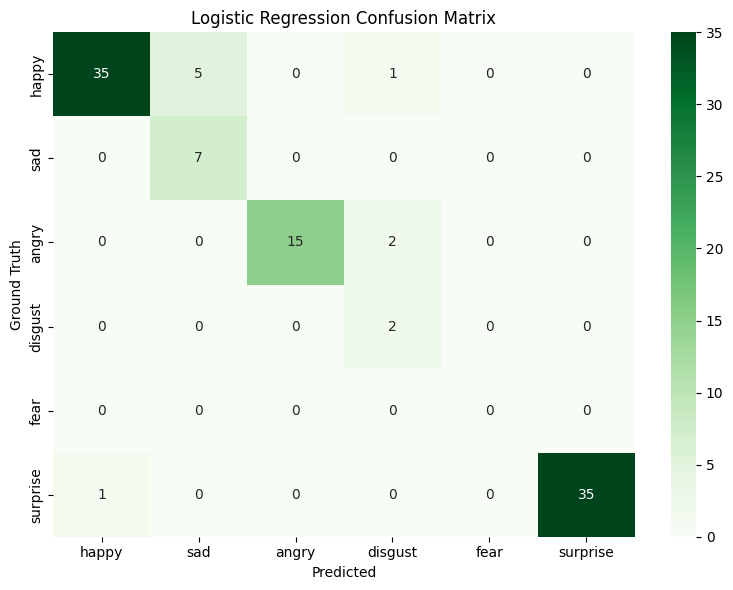

In [54]:
# Confusion Matrix for Logistic Regression
lr_cm = confusion_matrix(y_val, y_val_pred,
                         labels=['happy', 'sad', 'angry', 'disgust', 'fear', 'surprise'])

plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['happy', 'sad', 'angry', 'disgust', 'fear', 'surprise'],
            yticklabels=['happy', 'sad', 'angry', 'disgust', 'fear', 'surprise'])
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Ground Truth')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

模型比較摘要 (在 106 張乾淨樣本上的表現)
DeepFace (zero-shot):      0.708
FER (zero-shot):           0.806
Logistic Regression:       0.913




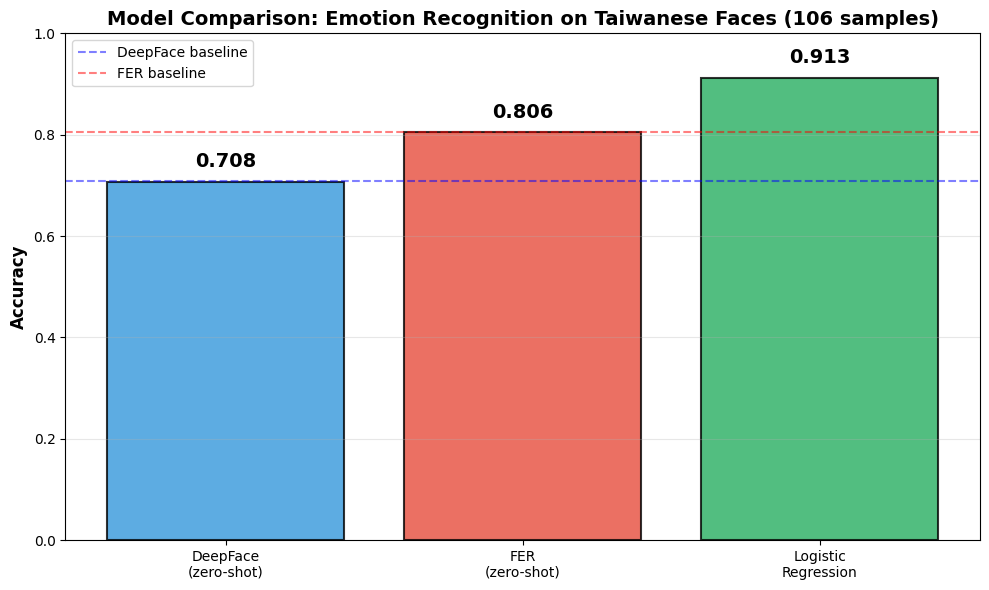

相對於 DeepFace 的改善: +29.0%
相對於 FER 的改善: +13.3%

🎉 成功！Logistic Regression 超越 DeepFace baseline (0.708)
🎉 成功！Logistic Regression 超越 FER baseline (0.806)


In [55]:
# 比較三個模型的準確率
print("="*60)
print("模型比較摘要 (在 106 張乾淨樣本上的表現)")
print("="*60)

# 從之前的結果讀取（如果有的話）
try:
    deepface_acc = accuracy_score(ground_truths, predictions)
except:
    deepface_acc = 0.708  # 之前的結果

try:
    fer_acc = accuracy_score(fer_ground_truths, fer_predictions)
except:
    fer_acc = 0.806  # 之前的結果

print(f"DeepFace (zero-shot):      {deepface_acc:.3f}")
print(f"FER (zero-shot):           {fer_acc:.3f}")
print(f"Logistic Regression:       {val_accuracy:.3f}")
print("\n")

# 視覺化比較
comparison_df = pd.DataFrame({
    'Model': ['DeepFace\n(zero-shot)', 'FER\n(zero-shot)', 'Logistic\nRegression'],
    'Accuracy': [deepface_acc, fer_acc, val_accuracy],
    'Type': ['Pre-trained', 'Pre-trained', 'Fine-tuned']
})

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#3498db', '#e74c3c', '#27ae60']
bars = ax.bar(comparison_df['Model'], comparison_df['Accuracy'],
              color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison: Emotion Recognition on Taiwanese Faces (106 samples)',
             fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.axhline(y=0.708, color='blue', linestyle='--', alpha=0.5, label='DeepFace baseline')
ax.axhline(y=0.806, color='red', linestyle='--', alpha=0.5, label='FER baseline')
ax.legend()

# 在柱狀圖上顯示數值
for i, (bar, acc) in enumerate(zip(bars, comparison_df['Accuracy'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{acc:.3f}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 計算改善幅度
improvement_over_deepface = (val_accuracy - deepface_acc) / deepface_acc * 100
improvement_over_fer = (val_accuracy - fer_acc) / fer_acc * 100

print(f"相對於 DeepFace 的改善: {improvement_over_deepface:+.1f}%")
print(f"相對於 FER 的改善: {improvement_over_fer:+.1f}%")

if val_accuracy > deepface_acc:
    print(f"\n🎉 成功！Logistic Regression 超越 DeepFace baseline ({deepface_acc:.3f})")
if val_accuracy > fer_acc:
    print(f"🎉 成功！Logistic Regression 超越 FER baseline ({fer_acc:.3f})")

用 Taiwanese 臉「微調最後一層」明顯比完全 zero-shot 套預訓練模型好很多。

## Step 5: Video Processing (vlog.mp4) Prediction

In [56]:
def extract_frame_features(frame):
    """
    從單一影片幀中萃取 519 維特徵向量

    Args:
        frame: OpenCV 讀取的影像 (numpy array)

    Returns:
        features (np.array): 519 維特徵向量 [DeepFace(512) + FER(7)]
        失敗則返回 None
    """
    try:
        # 1. 萃取 DeepFace embedding (512 維)
        deepface_result = DeepFace.represent(
            img_path=frame,
            model_name='VGG-Face',
            enforce_detection=False,
            detector_backend='opencv'
        )

        if isinstance(deepface_result, list) and len(deepface_result) > 0:
            deepface_embedding = np.array(deepface_result[0]['embedding'])
        else:
            return None

        # 2. 萃取 FER 特徵 (7 維)
        fer_result = fer_detector.detect_emotions(frame)

        if fer_result is None or len(fer_result) == 0:
            return None

        emotions = fer_result[0]['emotions']
        fer_features = np.array([
            emotions['angry'],
            emotions['disgust'],
            emotions['fear'],
            emotions['happy'],
            emotions['sad'],
            emotions['surprise'],
            emotions['neutral']
        ])

        # 3. 合併特徵
        combined_features = np.concatenate([deepface_embedding, fer_features])

        return combined_features

    except Exception as e:
        return None

print("✅ 影片幀特徵萃取函數定義完成")

✅ 影片幀特徵萃取函數定義完成


In [76]:
import cv2
from tqdm import tqdm

# ✅ 修正：使用本地路徑
video_path = '/content/drive/MyDrive/vlog.mp4'  # 本地路徑
output_path = 'vlog_lr_emotion_results.csv'

# 開啟影片
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"影片資訊:")
print(f"  FPS: {fps}")
print(f"  總幀數: {total_frames}")
print(f"  影片長度: {total_frames / fps:.1f} 秒")

# 每秒抽 1 幀進行分析
sample_interval = fps
frame_count = 0
results_lr = []  # Logistic Regression 結果
results_deepface = []  # DeepFace zero-shot 結果（用於比較）
failed_frames = 0

print(f"\n開始處理影片")

# 計算預期處理的幀數
expected_samples = total_frames // sample_interval

with tqdm(total=expected_samples, desc="處理影片幀") as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # 只處理每秒的第一幀
        if frame_count % sample_interval == 0:
            time_sec = frame_count // fps

            # 方法 1: 使用訓練好的 Logistic Regression
            features = extract_frame_features(frame)

            if features is not None:
                # 標準化特徵
                features_scaled = scaler.transform(features.reshape(1, -1))

                # 使用 Logistic Regression 預測
                emotion_lr = lr_model.predict(features_scaled)[0]

                results_lr.append({
                    'time_sec': time_sec,
                    'emotion': emotion_lr
                })
            else:
                failed_frames += 1
                results_lr.append({
                    'time_sec': time_sec,
                    'emotion': 'unknown'
                })

            # 方法 2: DeepFace zero-shot（用於比較）
            try:
                result = DeepFace.analyze(
                    frame,
                    actions=['emotion'],
                    detector_backend='opencv',
                    enforce_detection=False,
                    silent=True
                )
                result = result[0] if isinstance(result, list) else result
                emotion_deepface = result['dominant_emotion']
            except:
                emotion_deepface = 'unknown'

            results_deepface.append({
                'time_sec': time_sec,
                'emotion': emotion_deepface
            })

            pbar.update(1)

        frame_count += 1

cap.release()

# 轉換為 DataFrame
results_lr_df = pd.DataFrame(results_lr)
results_deepface_df = pd.DataFrame(results_deepface)

# 儲存結果
results_lr_df.to_csv(output_path, index=False)

print(f"\n✅ 影片處理完成")
print(f"   分析時間點數: {len(results_lr)}")
print(f"   失敗幀數: {failed_frames}")
print(f"   結果已儲存至: {output_path}")

print("\nLogistic Regression 結果預覽:")
print(results_lr_df.head(10))

影片資訊:
  FPS: 30
  總幀數: 1504
  影片長度: 50.1 秒

開始處理影片


處理影片幀: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it]


✅ 影片處理完成
   分析時間點數: 50
   失敗幀數: 0
   結果已儲存至: vlog_lr_emotion_results.csv

Logistic Regression 結果預覽:
   time_sec  emotion
0         0      sad
1         1      sad
2         2      sad
3         3    happy
4         4      sad
5         5  disgust
6         6      sad
7         7      sad
8         8      sad
9         9      sad


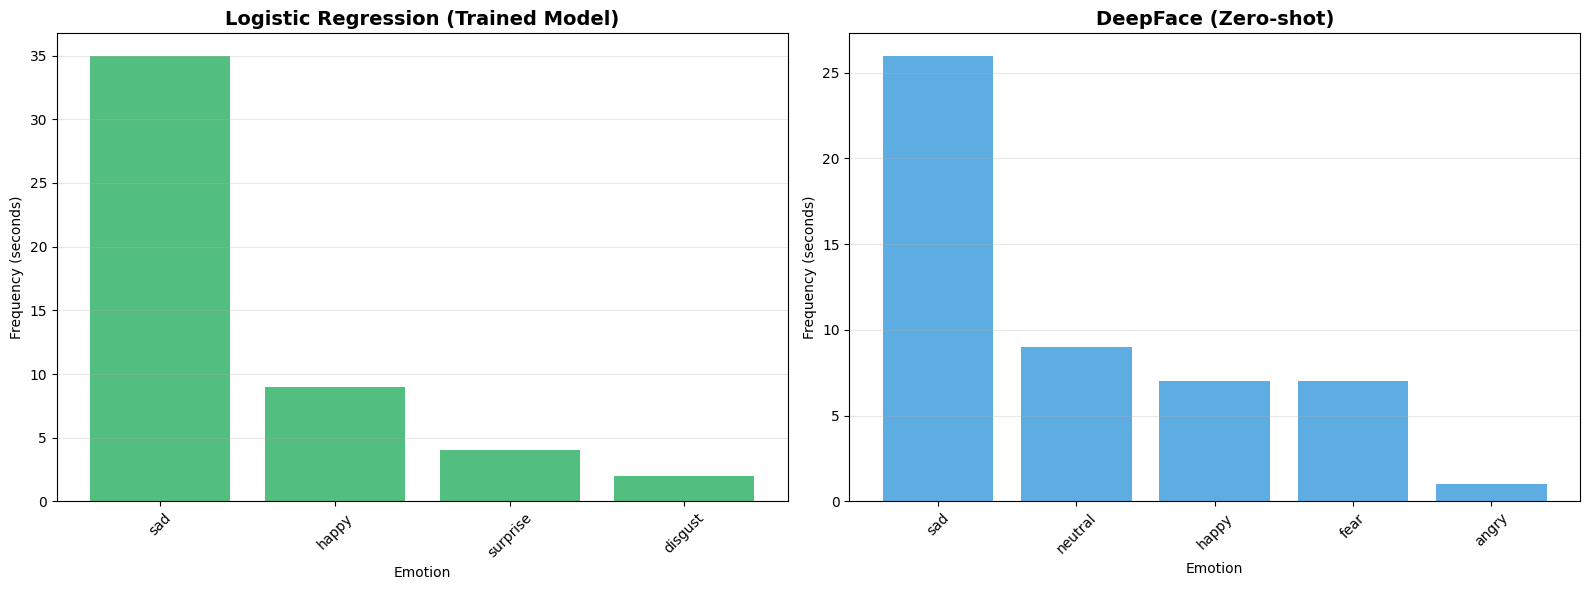

Logistic Regression 情緒分布:
  sad         :  35 秒 (70.0%)
  happy       :   9 秒 (18.0%)
  surprise    :   4 秒 (8.0%)
  disgust     :   2 秒 (4.0%)

DeepFace (Zero-shot) 情緒分布:
  sad         :  26 秒 (52.0%)
  neutral     :   9 秒 (18.0%)
  happy       :   7 秒 (14.0%)
  fear        :   7 秒 (14.0%)
  angry       :   1 秒 (2.0%)


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# 統計情緒分布
lr_emotion_counts = results_lr_df['emotion'].value_counts()
deepface_emotion_counts = results_deepface_df['emotion'].value_counts()

# 並排比較
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：Logistic Regression
axes[0].bar(lr_emotion_counts.index, lr_emotion_counts.values, color='#27ae60', alpha=0.8)
axes[0].set_title('Logistic Regression (Trained Model)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Frequency (seconds)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# 右圖：DeepFace zero-shot
axes[1].bar(deepface_emotion_counts.index, deepface_emotion_counts.values, color='#3498db', alpha=0.8)
axes[1].set_title('DeepFace (Zero-shot)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Frequency (seconds)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 詳細情緒佔比
print("="*60)
print("Logistic Regression 情緒分布:")
print("="*60)
for emotion, count in lr_emotion_counts.items():
    print(f"  {emotion:12s}: {count:3d} 秒 ({count/len(results_lr_df):.1%})")

print("\n" + "="*60)
print("DeepFace (Zero-shot) 情緒分布:")
print("="*60)
for emotion, count in deepface_emotion_counts.items():
    print(f"  {emotion:12s}: {count:3d} 秒 ({count/len(results_deepface_df):.1%})")

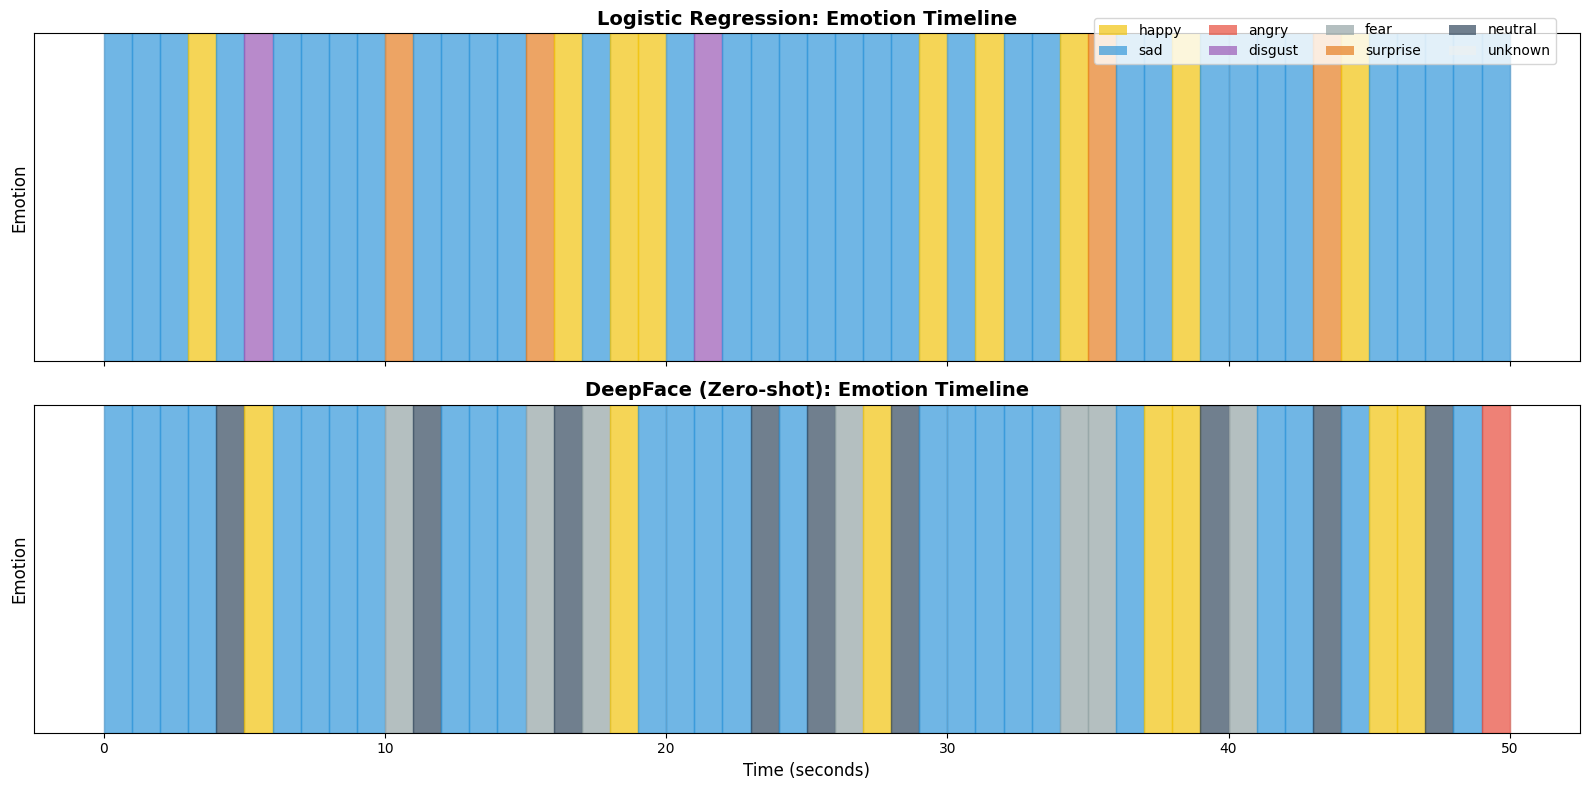

In [78]:
# 為情緒分配顏色
emotion_colors = {
    'happy': '#f1c40f',
    'sad': '#3498db',
    'angry': '#e74c3c',
    'disgust': '#9b59b6',
    'fear': '#95a5a6',
    'surprise': '#e67e22',
    'neutral': '#34495e',
    'unknown': '#ecf0f1'
}

# 繪製時間序列
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# 上圖：Logistic Regression
for i, row in results_lr_df.iterrows():
    color = emotion_colors.get(row['emotion'], '#000000')
    axes[0].axvspan(row['time_sec'], row['time_sec'] + 1,
                    color=color, alpha=0.7)

axes[0].set_ylabel('Emotion', fontsize=12)
axes[0].set_title('Logistic Regression: Emotion Timeline', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].set_yticks([])
axes[0].grid(axis='x', alpha=0.3)

# 下圖：DeepFace
for i, row in results_deepface_df.iterrows():
    color = emotion_colors.get(row['emotion'], '#000000')
    axes[1].axvspan(row['time_sec'], row['time_sec'] + 1,
                    color=color, alpha=0.7)

axes[1].set_xlabel('Time (seconds)', fontsize=12)
axes[1].set_ylabel('Emotion', fontsize=12)
axes[1].set_title('DeepFace (Zero-shot): Emotion Timeline', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].set_yticks([])
axes[1].grid(axis='x', alpha=0.3)

# 添加圖例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=emotion, alpha=0.7)
                   for emotion, color in emotion_colors.items()]
fig.legend(handles=legend_elements, loc='upper right', ncol=4,
           bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.show()

## Step 6: Testing Trained Model and Zero-shot on Custom Video

**Video Link**: [https://drive.google.com/file/d/1foGUvnT73yzf6cT5ZJvbk9pki3DtA2MR/view?usp=sharing](https://drive.google.com/file/d/1foGUvnT73yzf6cT5ZJvbk9pki3DtA2MR/view?usp=sharing)

In [73]:
import cv2
from tqdm import tqdm

# ✅ 修正：使用本地路徑
video_path = '/content/drive/MyDrive/my_example.mp4'  # 本地路徑
output_path = 'Myvlog_lr_emotion_results.csv'

# 開啟影片
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"影片資訊:")
print(f"  FPS: {fps}")
print(f"  總幀數: {total_frames}")
print(f"  影片長度: {total_frames / fps:.1f} 秒")

# 每秒抽 1 幀進行分析
sample_interval = fps
frame_count = 0
results_lr = []  # Logistic Regression 結果
results_deepface = []  # DeepFace zero-shot 結果（用於比較）
failed_frames = 0

print(f"\n開始處理影片")

# 計算預期處理的幀數
expected_samples = total_frames // sample_interval

with tqdm(total=expected_samples, desc="處理影片幀") as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # 只處理每秒的第一幀
        if frame_count % sample_interval == 0:
            time_sec = frame_count // fps

            # 方法 1: 使用訓練好的 Logistic Regression
            features = extract_frame_features(frame)

            if features is not None:
                # 標準化特徵
                features_scaled = scaler.transform(features.reshape(1, -1))

                # 使用 Logistic Regression 預測
                emotion_lr = lr_model.predict(features_scaled)[0]

                results_lr.append({
                    'time_sec': time_sec,
                    'emotion': emotion_lr
                })
            else:
                failed_frames += 1
                results_lr.append({
                    'time_sec': time_sec,
                    'emotion': 'unknown'
                })

            # 方法 2: DeepFace zero-shot（用於比較）
            try:
                result = DeepFace.analyze(
                    frame,
                    actions=['emotion'],
                    detector_backend='opencv',
                    enforce_detection=False,
                    silent=True
                )
                result = result[0] if isinstance(result, list) else result
                emotion_deepface = result['dominant_emotion']
            except:
                emotion_deepface = 'unknown'

            results_deepface.append({
                'time_sec': time_sec,
                'emotion': emotion_deepface
            })

            pbar.update(1)

        frame_count += 1

cap.release()

# 轉換為 DataFrame
results_lr_df = pd.DataFrame(results_lr)
results_deepface_df = pd.DataFrame(results_deepface)

# 儲存結果
results_lr_df.to_csv(output_path, index=False)

print(f"\n✅ 影片處理完成")
print(f"   分析時間點數: {len(results_lr)}")
print(f"   失敗幀數: {failed_frames}")
print(f"   結果已儲存至: {output_path}")

print("\nLogistic Regression 結果預覽:")
print(results_lr_df.head(10))

影片資訊:
  FPS: 30
  總幀數: 685
  影片長度: 22.8 秒

開始處理影片


處理影片幀: 23it [02:22,  6.19s/it]


✅ 影片處理完成
   分析時間點數: 23
   失敗幀數: 2
   結果已儲存至: Myvlog_lr_emotion_results.csv

Logistic Regression 結果預覽:
   time_sec   emotion
0         0   disgust
1         1  surprise
2         2   disgust
3         3  surprise
4         4   disgust
5         5  surprise
6         6  surprise
7         7  surprise
8         8  surprise
9         9   disgust


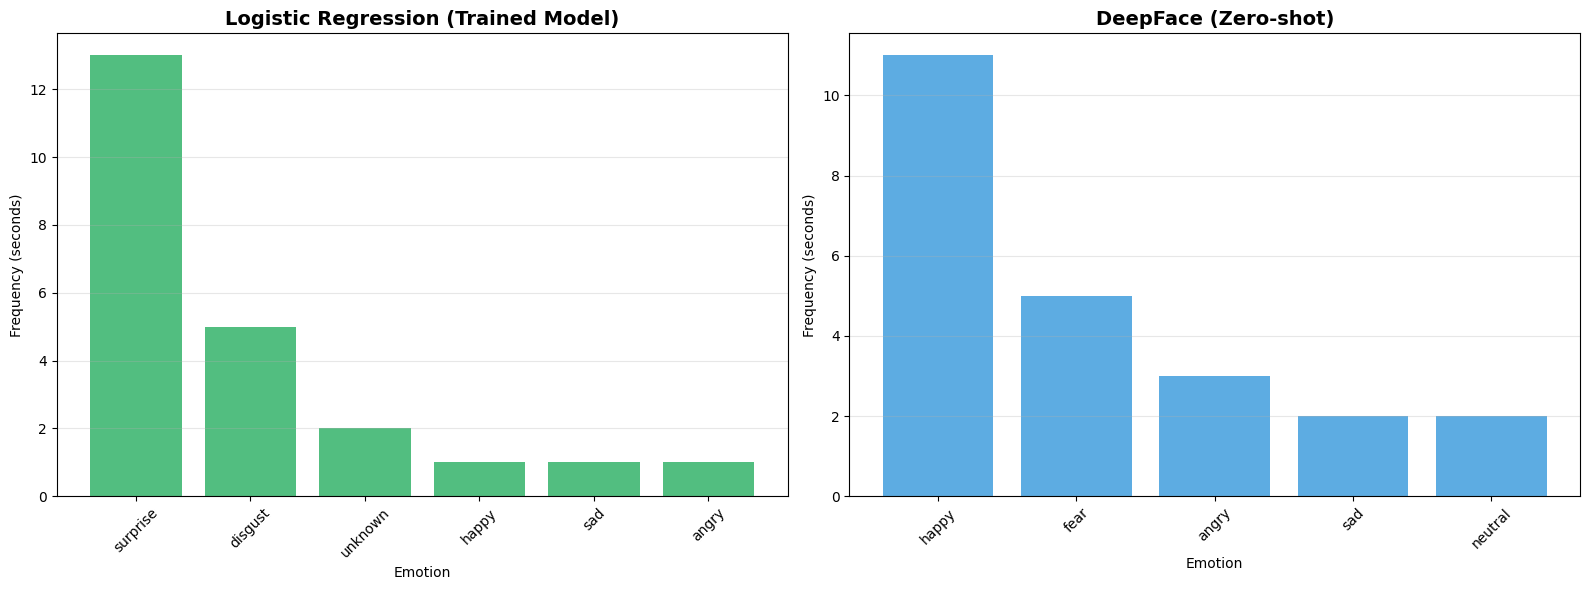

Logistic Regression 情緒分布:
  surprise    :  13 秒 (56.5%)
  disgust     :   5 秒 (21.7%)
  unknown     :   2 秒 (8.7%)
  happy       :   1 秒 (4.3%)
  sad         :   1 秒 (4.3%)
  angry       :   1 秒 (4.3%)

DeepFace (Zero-shot) 情緒分布:
  happy       :  11 秒 (47.8%)
  fear        :   5 秒 (21.7%)
  angry       :   3 秒 (13.0%)
  sad         :   2 秒 (8.7%)
  neutral     :   2 秒 (8.7%)


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# 統計情緒分布
lr_emotion_counts = results_lr_df['emotion'].value_counts()
deepface_emotion_counts = results_deepface_df['emotion'].value_counts()

# 並排比較
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：Logistic Regression
axes[0].bar(lr_emotion_counts.index, lr_emotion_counts.values, color='#27ae60', alpha=0.8)
axes[0].set_title('Logistic Regression (Trained Model)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Frequency (seconds)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# 右圖：DeepFace zero-shot
axes[1].bar(deepface_emotion_counts.index, deepface_emotion_counts.values, color='#3498db', alpha=0.8)
axes[1].set_title('DeepFace (Zero-shot)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Frequency (seconds)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 詳細情緒佔比
print("="*60)
print("Logistic Regression 情緒分布:")
print("="*60)
for emotion, count in lr_emotion_counts.items():
    print(f"  {emotion:12s}: {count:3d} 秒 ({count/len(results_lr_df):.1%})")

print("\n" + "="*60)
print("DeepFace (Zero-shot) 情緒分布:")
print("="*60)
for emotion, count in deepface_emotion_counts.items():
    print(f"  {emotion:12s}: {count:3d} 秒 ({count/len(results_deepface_df):.1%})")

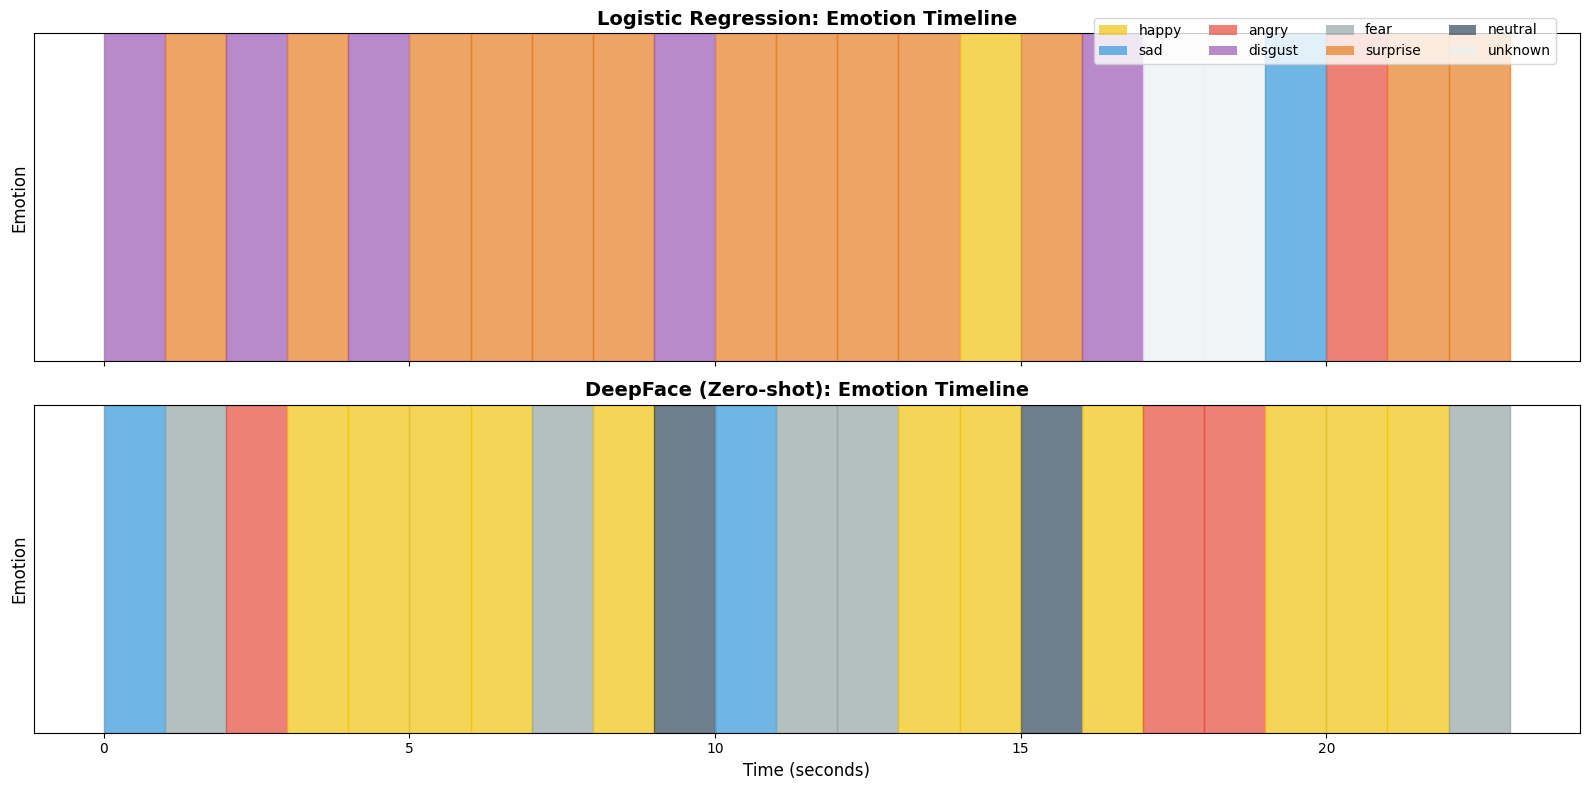

In [75]:
# 為情緒分配顏色
emotion_colors = {
    'happy': '#f1c40f',
    'sad': '#3498db',
    'angry': '#e74c3c',
    'disgust': '#9b59b6',
    'fear': '#95a5a6',
    'surprise': '#e67e22',
    'neutral': '#34495e',
    'unknown': '#ecf0f1'
}

# 繪製時間序列
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# 上圖：Logistic Regression
for i, row in results_lr_df.iterrows():
    color = emotion_colors.get(row['emotion'], '#000000')
    axes[0].axvspan(row['time_sec'], row['time_sec'] + 1,
                    color=color, alpha=0.7)

axes[0].set_ylabel('Emotion', fontsize=12)
axes[0].set_title('Logistic Regression: Emotion Timeline', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].set_yticks([])
axes[0].grid(axis='x', alpha=0.3)

# 下圖：DeepFace
for i, row in results_deepface_df.iterrows():
    color = emotion_colors.get(row['emotion'], '#000000')
    axes[1].axvspan(row['time_sec'], row['time_sec'] + 1,
                    color=color, alpha=0.7)

axes[1].set_xlabel('Time (seconds)', fontsize=12)
axes[1].set_ylabel('Emotion', fontsize=12)
axes[1].set_title('DeepFace (Zero-shot): Emotion Timeline', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].set_yticks([])
axes[1].grid(axis='x', alpha=0.3)

# 添加圖例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=emotion, alpha=0.7)
                   for emotion, color in emotion_colors.items()]
fig.legend(handles=legend_elements, loc='upper right', ncol=4,
           bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.show()